# Gripper assembly and testing 
# Srikumar Muralidharan 

Complete Mechanical and Electrical assembly of the servo gripper as detailed in the lecture notes. Done!<br>
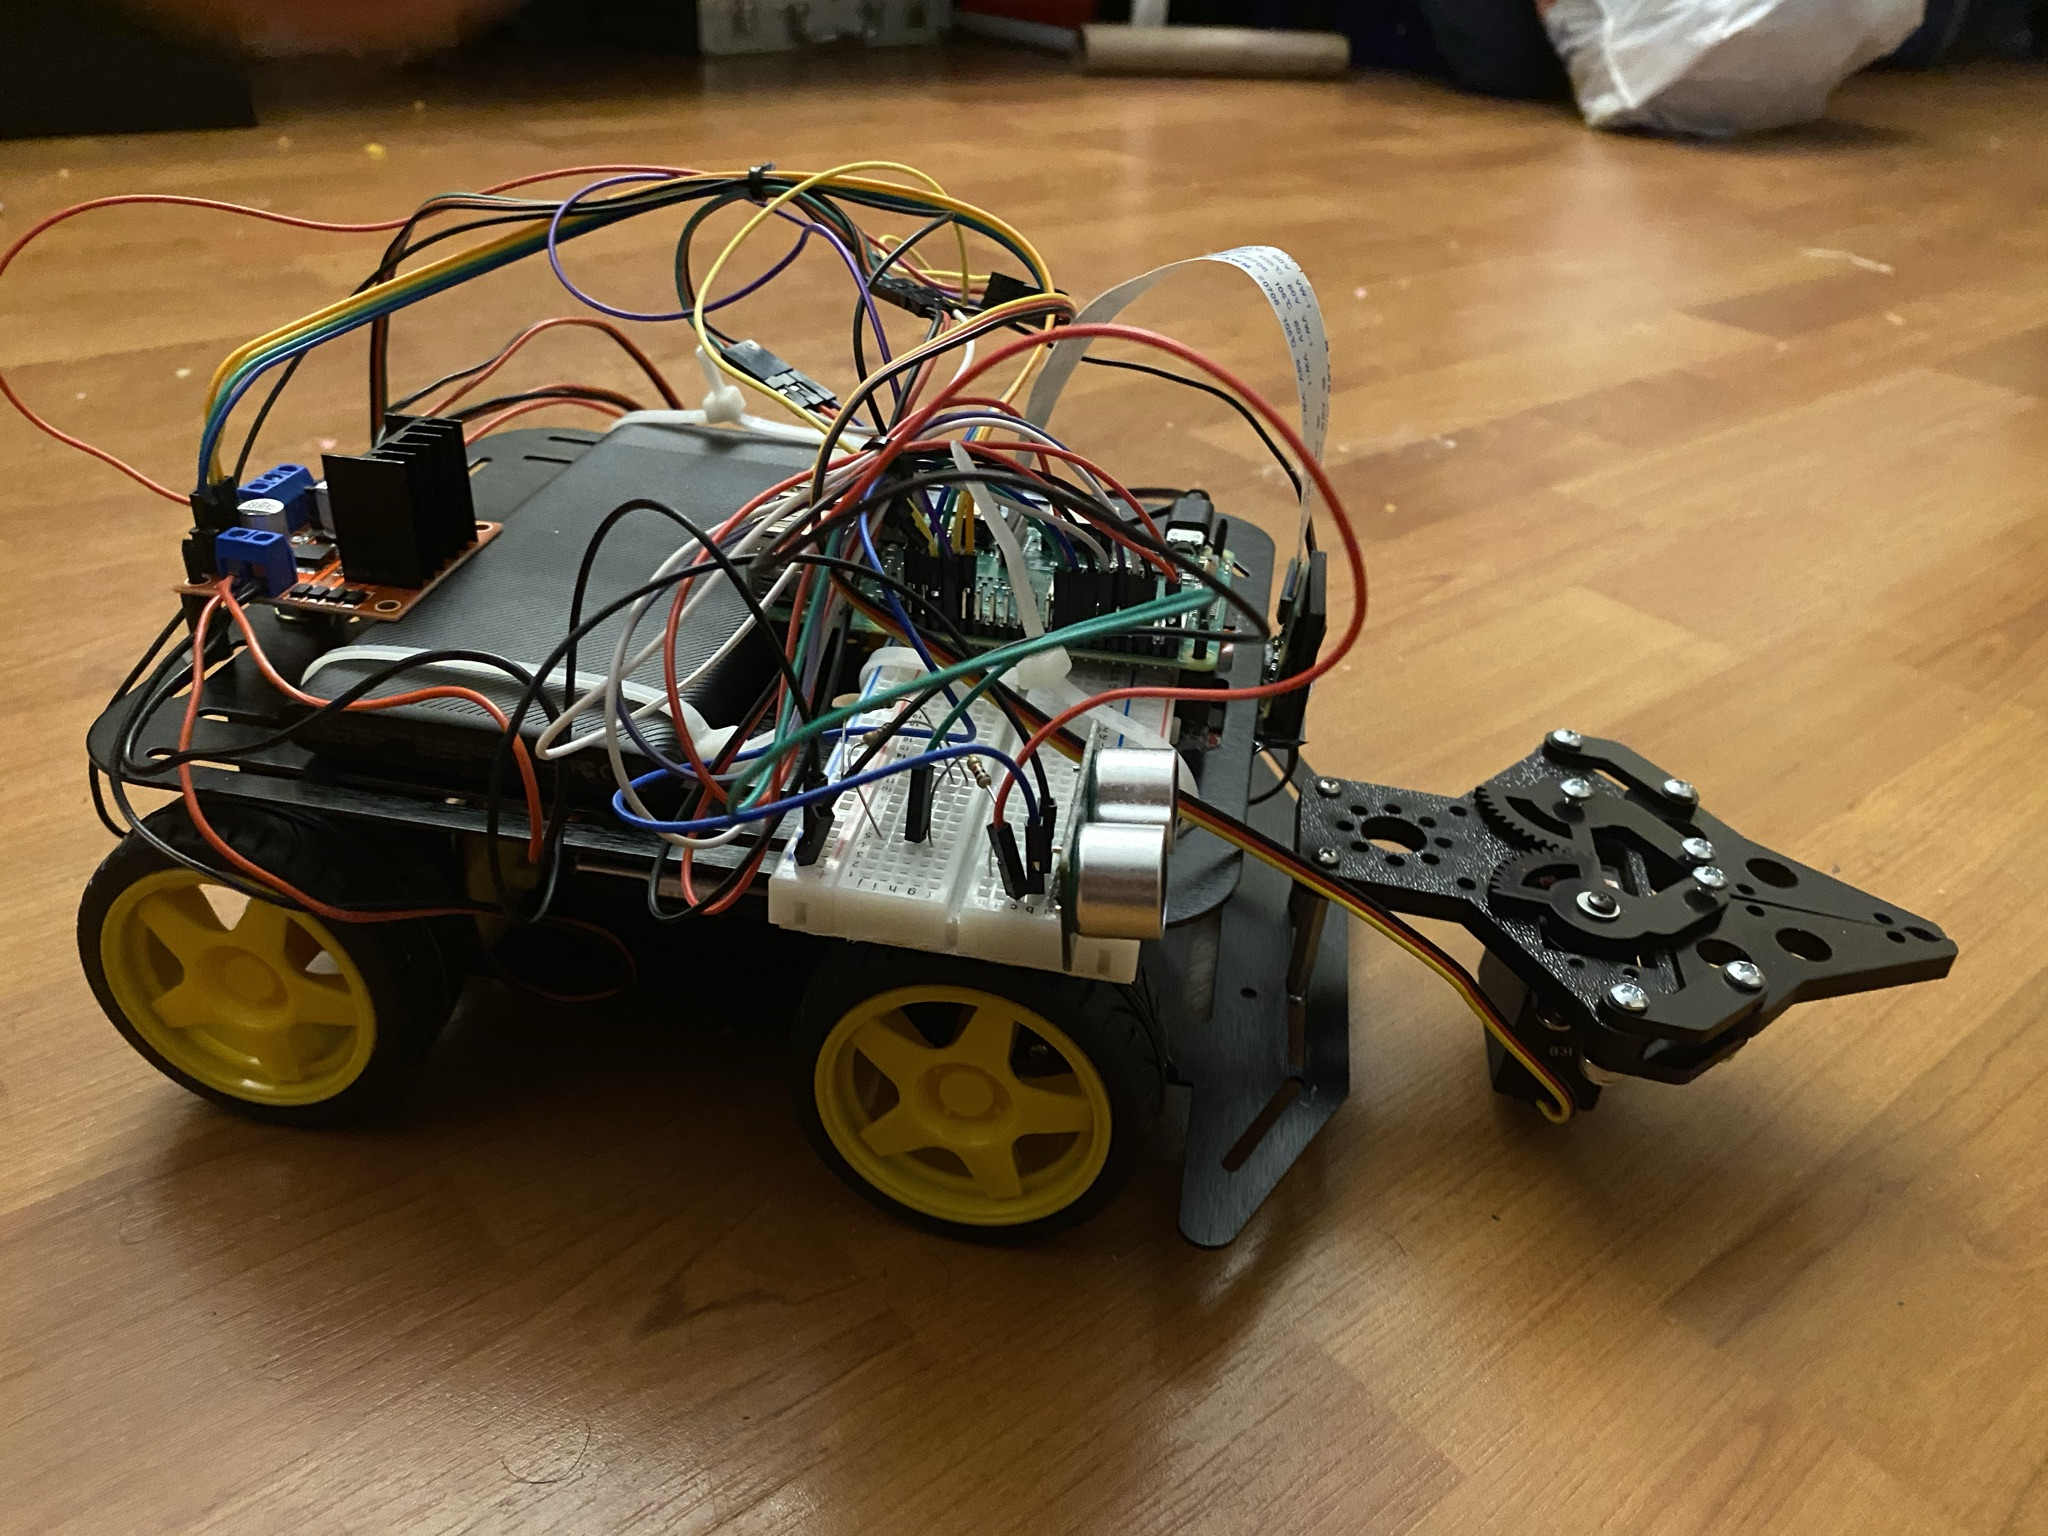

Part 2: Create servocontrol01.py. <br>
Steps: <br>
a. Set pin 36 as output. Servo motors use a 50 Hz control signal. Slowly open and close by changing Duty cycle.<br>
b. Record images using Pi cam.<br>
c. Print Duty cycle on top of the image.<br>
d. Stitch into a video.<br>

In [ ]:
#Execute only in RPi.

from picamera.array import PiRGBArray
from picamera import PiCamera
import time
import cv2
import numpy as np
import imutils
import datetime
import RPi.GPIO as GPIO


def Main():    
    GPIO.setmode(GPIO.BOARD)
    GPIO.setup(36, GPIO.OUT)
    pwm = GPIO.PWM(36,50)
    pwm.start(7.5)
    #initialize the Raspberry Pi camera
    camera=PiCamera()
    camera.resolution=(640,480)
    camera.framerate=10
    rawCapture=PiRGBArray(camera,size=(640,480))
    time.sleep(0.5)
    fourcc=cv2.VideoWriter_fourcc(*'XVID')
    out=cv2.VideoWriter('Gripper.avi',fourcc,10,(640,480))
    #allow the camera to warmup
    time.sleep(0.1)
    
    i= 7.5
    counter = 0
    for frame in camera.capture_continuous(rawCapture,format="bgr",use_video_port=False):
        image = frame.array
        img1 = cv2.flip(image,-1)
        if counter==0:
            i+=0.5
            print(i)
            if (i==12.5):
                counter=1
        if counter==1:
            if i==7.0:
                break
            i-=0.5
            print(i)
        pwm.ChangeDutyCycle(i)
        cv2.putText(img1,'Duty:'+str(i)+'%',(10,100),cv2.FONT_HERSHEY_DUPLEX,3,(255,0,255),2)
        time.sleep(0.5)
        #show the frame to our screen
        cv2.imshow("Final",img1)
        out.write(img1)
        rawCapture.truncate(0)
    
    out.release()
    cv2.destroyAllWindows()
    pwm.stop()
    GPIO.cleanup()
        
if __name__ == '__main__':
    Main()

A link to the video file : https://youtu.be/DgSLZYjPvfQ

Distance measurements to be incorporated with the teleoperation. I had incorporated both distance as well as gripper opening and closing in the same code set. The code is as follows:

In [ ]:
#Execute only in RPi.

from picamera.array import PiRGBArray
from picamera import PiCamera
import time
import cv2
import numpy as np
import imutils
import datetime
import RPi.GPIO as gpio

# Define pin allocation
trig = 16
echo = 18

def init():
    gpio.setmode(gpio.BOARD)
    gpio.setup(31,gpio.OUT)         #IN1
    gpio.setup(33,gpio.OUT)         #IN2
    gpio.setup(35,gpio.OUT)         #IN3
    gpio.setup(37,gpio.OUT)         #IN4
    gpio.setup(trig,gpio.OUT)       #trig
    gpio.setup(echo,gpio.IN)        #echo
    gpio.setup(36,gpio.OUT)         #Servo
    
    
def gameover():
    #set all pins low
    gpio.output(31, False)
    gpio.output(33, False)
    gpio.output(35, False)
    gpio.output(37, False)
    gpio.output(36, False)
    gpio.output(trig, False)
    
def forward(tf):
    init()
    # Left wheels
    gpio.output(31, True)
    gpio.output(33, False)
    # Right wheels
    gpio.output(35, False)
    gpio.output(37, True)
    # Wait
    time.sleep(tf)
    # Send all pins low and cleanup
    gameover()
    gpio.cleanup()
    
    
def reverse(tf):
    init()
    # Left wheels
    gpio.output(31, False)
    gpio.output(33, True)
    # Right wheels
    gpio.output(35, True)
    gpio.output(37, False)
    # Wait
    time.sleep(tf)
    # Send all pins low and cleanup
    gameover()
    gpio.cleanup()
    
def pivotleft(tf):
    init()
    # Left wheels
    gpio.output(31, False)
    gpio.output(33, True)
    # Right wheels
    gpio.output(35, False)
    gpio.output(37, True)
    # Wait
    time.sleep(tf)
    # Send all pins low and cleanup
    gameover()
    gpio.cleanup()
    
def pivotright(tf):
    init()
    # Left wheels
    gpio.output(31, True)
    gpio.output(33, False)
    # Right wheels
    gpio.output(35, True)
    gpio.output(37, False)
    # Wait
    time.sleep(tf)
    # Send all pins low and cleanup
    gameover()
    gpio.cleanup()

def key_input(event):
    init()
    print("Key: ", event)
    key_press = event
    tf=1
    
    if key_press.lower() == 'w':
        forward(tf)
    elif key_press.lower() == 's':
        reverse(tf)
    elif key_press.lower() == 'a':
        pivotleft(tf)
    elif key_press.lower() == 'd':
        pivotright(tf)
    else:
        print("Invalid key pressed!")
        
def CalcDist():
    init()
    #ensure that trigger output is pulled to false
    gpio.output(trig, False)
    time.sleep(0.05)
    
    #Generate trigger pulse
    gpio.output(trig, True)
    time.sleep(0.00001)
    gpio.output(trig, False)
    
    # Generate echo time signal
    while gpio.input(echo) == 0:
    	pulse_start = time.time()
    while gpio.input(echo) == 1:
    	pulse_end = time.time()
    pulse_duration = pulse_end-pulse_start
    
    dist = pulse_duration*17150
    dist = round(dist,2)
    gameover()
    gpio.cleanup()
    return(dist)   

def Main():
    init()
    pwm = gpio.PWM(36,50)
    pwm.start(7.5)
    #initialize the Raspberry Pi camera
    camera=PiCamera()
    camera.resolution=(640,480)
    camera.framerate=2
    rawCapture=PiRGBArray(camera,size=(640,480))
    time.sleep(0.5)
    fourcc=cv2.VideoWriter_fourcc(*'XVID')
    out=cv2.VideoWriter('Teleop.avi',fourcc,10,(640,480))
    #allow the camera to warmup
    time.sleep(0.1)
    counter=0
    for frame in camera.capture_continuous(rawCapture, format="bgr", use_video_port=True):        
        image = frame.array
        image = cv2.flip(image,-1)
        #Opening Gripper
        if counter==0:
            pwm.ChangeDutyCycle(12.5)
            time.sleep(0.5)
            out.write(image)
        key_press=input("Enter WASD/OCP: ")
        if key_press=='o':
            pwm.ChangeDutyCycle(12.5)
            time.sleep(0.5)
        elif key_press=='c':
            pwm.ChangeDutyCycle(7.5)
            time.sleep(0.5)
        elif key_press=='p':
            pwm.ChangeDutyCycle(10)
            time.sleep(0.5)
            pwm.stop()
            break
        else:
            key_input(key_press)
        dist = CalcDist()
        print("Dist: "+str(dist)+'cm')
        if dist<50:
            print("obstacle ahead")
        out.write(image)
        rawCapture.truncate(0)
        counter=1
    out.release()
    cv2.destroyAllWindows()
        
if __name__=='__main__':
    Main()

A resultant screenshot associated with the distance measurement is attached: <br>
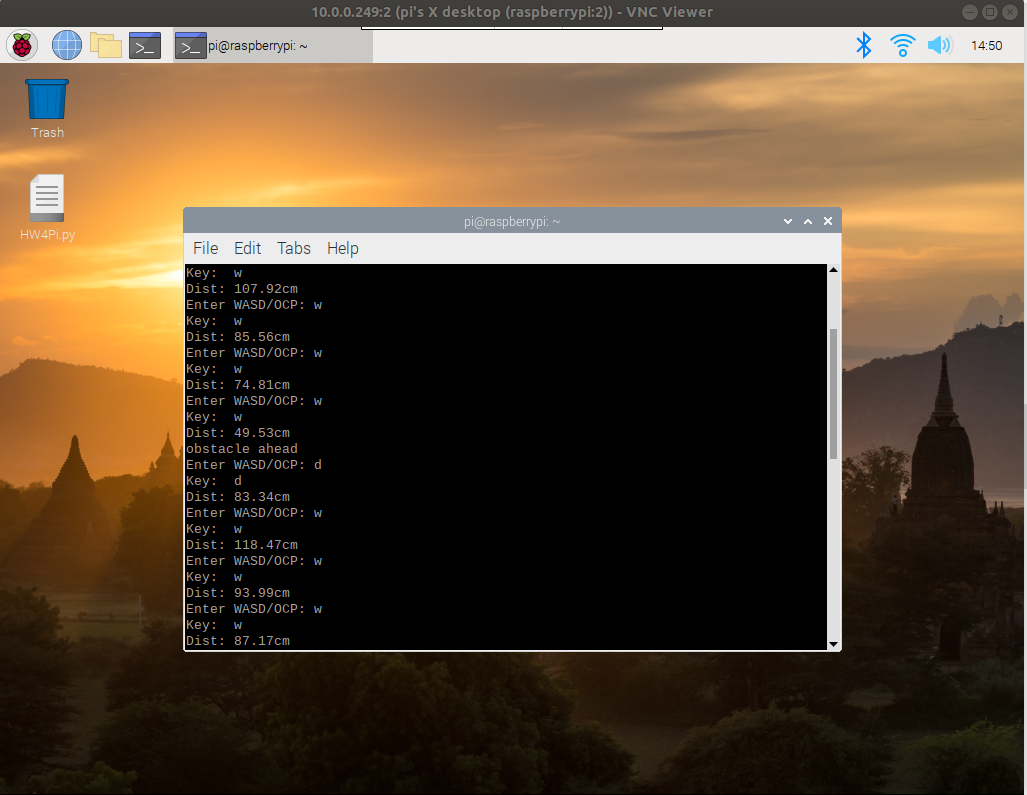

Part 4: Picking up objects. The code remains the same as attached above. Please watch this video:
https://youtu.be/OP2gd3kXTq8